In [4]:
import numpy as np
from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [5]:
# define paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig1_images_supp/waveforms/'

In [6]:
mice = ['Pisa', 'Hanover', 'Calais', # cue poor
        'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich (old)
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich (new, NP9 = male)
mouse_IDs = ['1c', '2a', '3a', '6a', '6b', '7a', '7b', '7c', '9a', ' 9b', '9c', '9d', '10a']
sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2'], # Hanover
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1'], # Seattle
            ['1005_2'],  # Portland
            ['1007_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
            ['1114_1', '1118_1'], # Vancouver
            ['1130_1', '1201_1', '1129_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

In [7]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : pink
double track : green/pink
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

In [8]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}  

In [9]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        d['cells'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_cellIDs.npy')
        
        # filter sessions with deleted AP/ML cells
        filt_file = data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_idx.npy'
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for probe mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]
        
        N_cells += d['cells'].shape[0]

Calais_0713_2 corrected for probe mistargeting
Toronto_1112_1 corrected for probe mistargeting
Mumbai_1130_1 corrected for probe mistargeting


In [10]:
# load the behavioral data
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        folder = base + m + '/'
        data_file = m + '_' + s + '_data.mat'
        behavior = get_data.loadData(folder + data_file)
        d['behavior'] = behavior

G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0430_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0501_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0502_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Hanover/Hanover_0615_2_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Calais/Calais_0713_2_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])
G:/My Drive/Giocomo Lab/RandomForage/Seattle/Seattle_1005_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])
G:/My Drive/Giocomo Lab/RandomForage/Seattle/Seattle_1006_1_data.mat

In [11]:
# load the epoch trials and load/re-save average and std of waveforms
oak_path = 'Z:/giocomo/export/data/Projects/RandomForage_NPandH3/ProcessedData/'
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        trial_folder = base + 'Dynamic MEC Coding Project/fig1_images_supp/waveform_info/'
        d['epoch_trials'] = np.load(trial_folder + '{}_{}_epoch_trials.npy'.format(m, s))
        
        # get waveform mean and STD
        waveform_avg_file = trial_folder + '{}_{}_mean_waveforms.npy'.format(m, s)
        waveform_std_file = trial_folder + '{}_{}_stddev_waveforms.npy'.format(m, s)   
        if Path(waveform_avg_file).exists():
            d['waveform_avg'] = np.load(waveform_avg_file)
            d['waveform_std'] = np.load(waveform_std_file)
        else:
            # get file base
            if m in ['Calais', 'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador']:
                date = s
            else:
                date = s.split('_')
                date = date[0]
            session_folder = '{}/{}_{}_g0/'.format(m, m, date)

            # load from oak and re-save locally
            oak_waveform_avg_file = oak_path + session_folder + 'mean_waveforms.npy'
            oak_waveform_std_file = oak_path + session_folder + 'stddev_waveforms.npy'                       
            if Path(oak_waveform_avg_file).exists():
                d['waveform_avg'] = np.load(oak_waveform_avg_file)
                d['waveform_std'] = np.load(oak_waveform_std_file)
                np.save(waveform_avg_file, d['waveform_avg'])
                np.save(waveform_std_file, d['waveform_std'])
            else:
                print('no waveform data for {}_{}!'.format(m, s))

In [12]:
''' get the channel associated with each cell:
- get cell depth : sp['spike_depth']
- find the channel closest in depth : sp['ycoords']
'''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        cells = d['cells']
        sp = d['behavior']['sp']
        depth_unsorted = sp['spike_depth'].copy()
        
        # get all good cells
        cgs = sp['cgs'].copy()
        cids = sp['cids'].copy()
        good_cells = cids[cgs == 2]
        
        # get depth for each MEC cell
        depth = np.zeros(cells.shape[0])
        for i, c in enumerate(cells):
            depth[i] = depth_unsorted[good_cells==c]
            
        # get nearest channel
        # there are 385 channels and 379 ycoords...so I'm calling those the middle 379 channels?
        channel_depths = sp['ycoords'].copy()
        channels = np.zeros(cells.shape[0])
        for i, y in enumerate(depth):
            channels[i] = 3 + np.argmin(np.abs(channel_depths - y))
        d['cell_channels'] = channels.astype(int)

In [14]:
# get session colors
N_sessions = 0
session_colors = []
session_names = []
for i, m in enumerate(mice):
    session = sessions[i]
    ID = mouse_IDs[i]
    for s in session:
        if m in ['Pisa', 'Hanover', 'Calais']:
            session_colors.append(cp_color)
        else:
            session_colors.append(cr_color)
        N_sessions += 1
        session_names.append(s)

In [22]:
''' compare waveforms across maps for all sessions: z-score '''
all_z_scores = []
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        waveform_avg = d['waveform_avg'].copy()
        waveform_std = d['waveform_std'].copy()
        n_epochs, n_cells, n_channels, n_samples = waveform_avg.shape
        n_pairs = n_epochs//2
        
        # for each cell, grab just the 20 best channels
        cell_channels = d['cell_channels'].copy()
        wf_avg = np.zeros((n_epochs, n_cells, 20, n_samples))
        wf_std = np.zeros((n_epochs, n_cells, 20, n_samples))
        for i, ch in enumerate(cell_channels):
            if ch < 10:
                wf_avg[:, i, :, :] = waveform_avg[:, i, :20, :]
                wf_std[:, i, :, :] = waveform_std[:, i, :20, :]
            elif ch > 375:
                wf_avg[:, i, :, :] = waveform_avg[:, i, 365:, :]
                wf_std[:, i, :, :] = waveform_std[:, i, 365:, :]                
            else:
                wf_avg[:, i, :, :] = waveform_avg[:, i, ch-10:ch+10, :]
                wf_std[:, i, :, :] = waveform_std[:, i, ch-10:ch+10, :]
                
        # avoid round-off errors
        wf_std[wf_std < 1e-10] = 1e-10
        wf_std[np.isnan(wf_std)] = 1e-10
        
        # compute z-score for each sample
        avg_z_score = np.zeros(n_cells)
        for p in range(n_pairs):
            i = 2*p
            mean_diff = wf_avg[i, :, :, :] - wf_avg[i+1, :, :, :]
            pooled_var = np.sqrt((wf_std[i, :, :, :]**2 + wf_std[i+1, :, :, :]**2) / 2)
            z_score = np.nanmedian(np.abs(mean_diff / pooled_var), axis=(1, 2))
            avg_z_score += z_score.ravel()
        avg_z_score = avg_z_score[~np.isnan(avg_z_score)]
        avg_z_score /= n_pairs
        
        d['z_scores'] = avg_z_score
        all_z_scores.append(avg_z_score)
        outliers = np.sum((avg_z_score < -1) | (avg_z_score > 1))
        print('{}_{}: {}% of samples are outside 1 standard deviation'.format(m, s, 
                                                                              np.round((outliers/avg_z_score.shape[0])*100, 2)))

C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
C:\Users\ilow1\AppData\Roaming\Python\Python36\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Pisa_0430_1: 0.0% of samples are outside 1 standard deviation
Pisa_0501_1: 0.0% of samples are outside 1 standard deviation
Pisa_0502_1: 0.0% of samples are outside 1 standard deviation
Hanover_0615_2: 0.0% of samples are outside 1 standard deviation
Calais_0713_2: 0.0% of samples are outside 1 standard deviation
Seattle_1005_1: 0.0% of samples are outside 1 standard deviation
Seattle_1006_1: 0.0% of samples are outside 1 standard deviation
Seattle_1007_1: 0.0% of samples are outside 1 standard deviation
Portland_1005_2: 0.0% of samples are outside 1 standard deviation
Quebec_1007_1: 0.0% of samples are outside 1 standard deviation
Toronto_1111_1: 0.0% of samples are outside 1 standard deviation
Toronto_1112_1: 0.0% of samples are outside 1 standard deviation
Toronto_1113_1: 0.0% of samples are outside 1 standard deviation
Toronto_1114_1: 0.0% of samples are outside 1 standard deviation
Toronto_1115_1: 0.0% of samples are outside 1 standard deviation
Toronto_1117_1: 0.0% of samples are

In [23]:
# get quartiles and means
pct_5 = np.zeros(len(all_z_scores))
pct_95 = np.zeros(len(all_z_scores))
avg_z = np.zeros(len(all_z_scores))
for i, z in enumerate(all_z_scores):
    pct_5[i] = np.percentile(z, 5)
    pct_95[i] = np.percentile(z, 95)
    avg_z[i] = np.median(z)

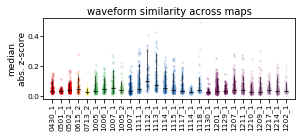

In [24]:
f, ax = plt.subplots(1, 1, figsize=(4.5, 1.5))

PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
POSITIONS = np.arange(N_sessions)
JIT = 0.05

# plot median z-score for each cell
for i, z in enumerate(all_z_scores):
    n_cells = z.shape[0]
    jit = np.random.randn(n_cells) * JIT
    ax.scatter(np.full(n_cells, POSITIONS[i])+jit, z, 
                s=PT_SIZE, lw=PT_LW, color=session_colors[i], alpha=0.3, zorder=1)

# mark median and 95th percentiles
ax.plot(POSITIONS, avg_z, '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=1)
ax.vlines(POSITIONS, pct_5, pct_95, lw=LW_PCT, colors='k', linestyles='solid', zorder=2, alpha=1)

# labels, axes
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_ylabel('median\nabs. z-score', fontsize=9, labelpad=1)
ax.set_xlim(-1, N_sessions)
ax.set_xticks(POSITIONS)
ax.set_xticklabels(session_names, rotation=90)
ax.set_title('waveform similarity across maps', fontsize=10, pad=3)

f.savefig(save_folder + 'waveform_zscores.png', dpi=400, bbox_inches='tight')
plt.show()

In [25]:
all_zscores_array = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        all_zscores_array = np.append(all_zscores_array, d['z_scores'].copy())

print('median correlation across 2-map sessions = {:.4}'.format(np.median(all_zscores_array)))
print('95th percentile correlation across 2-map sessions = {:.4}'.format(np.percentile(all_zscores_array, 95)))

median correlation across 2-map sessions = 0.03847
95th percentile correlation across 2-map sessions = 0.1373


In [15]:
''' compare waveforms across maps for all sessions: correlation '''
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

all_correlations = []
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        waveform_avg = d['waveform_avg'].copy()
        waveform_std = d['waveform_std'].copy()
        n_epochs, n_cells, n_channels, n_samples = waveform_avg.shape
        n_pairs = n_epochs//2
        print('{}_{} n cells = {}, n epochs = {}'.format(m, s, n_cells, n_epochs))
        
        # for each cell, grab the avg waveforms for just the 20 best channels
        cell_channels = d['cell_channels'].copy()
        wf_avg = np.zeros((n_epochs, n_cells, 20, n_samples))
        for i, ch in enumerate(cell_channels):
            if ch < 10:
                wf_avg[:, i, :, :] = waveform_avg[:, i, :20, :]
            elif ch > 375:
                wf_avg[:, i, :, :] = waveform_avg[:, i, 365:, :]
            else:
                wf_avg[:, i, :, :] = waveform_avg[:, i, ch-10:ch+10, :]
        
        # compute correlation for flattened vectors
        avg_corr = np.zeros(n_cells)
        for p in range(n_pairs):
            i = 2*p
            flat_wf_avg_pre = np.reshape(wf_avg[i, :, :, :], (n_cells, -1))
            flat_wf_avg_post = np.reshape(wf_avg[i+1, :, :, :], (n_cells, -1))
            flat_wf_avg = np.row_stack((flat_wf_avg_pre, flat_wf_avg_post))
            corr_vec = np.abs(pdist(flat_wf_avg, 'correlation')-1)
            correlations = np.diagonal(squareform(corr_vec), offset=n_cells)
            avg_corr += correlations
        avg_corr = avg_corr[~np.isnan(avg_corr)]
        avg_corr = avg_corr/n_pairs
        
        d['correlations'] = avg_corr
        all_correlations.append(avg_corr)

Pisa_0430_1 n cells = 227, n epochs = 6
Pisa_0501_1 n cells = 122, n epochs = 6
Pisa_0502_1 n cells = 294, n epochs = 6
Hanover_0615_2 n cells = 72, n epochs = 2
Calais_0713_2 n cells = 46, n epochs = 2
Seattle_1005_1 n cells = 207, n epochs = 2
Seattle_1006_1 n cells = 196, n epochs = 6
Seattle_1007_1 n cells = 96, n epochs = 2
Portland_1005_2 n cells = 149, n epochs = 2
Quebec_1007_1 n cells = 199, n epochs = 2
Toronto_1111_1 n cells = 184, n epochs = 6
Toronto_1112_1 n cells = 74, n epochs = 6
Toronto_1113_1 n cells = 139, n epochs = 2
Toronto_1114_1 n cells = 213, n epochs = 2
Toronto_1115_1 n cells = 244, n epochs = 2
Toronto_1117_1 n cells = 162, n epochs = 4
Vancouver_1114_1 n cells = 117, n epochs = 2
Vancouver_1118_1 n cells = 132, n epochs = 6
Mumbai_1130_1 n cells = 112, n epochs = 2
Mumbai_1201_1 n cells = 356, n epochs = 2
Mumbai_1129_1 n cells = 156, n epochs = 6
Kerala_1207_1 n cells = 227, n epochs = 6
Goa_1211_1 n cells = 204, n epochs = 2
Goa_1210_1 n cells = 258, n e

In [16]:
# get quartiles and means
pct_5 = np.zeros(len(all_correlations))
pct_95 = np.zeros(len(all_correlations))
avg_corr = np.zeros(len(all_correlations))
for i, z in enumerate(all_correlations):
    pct_5[i] = np.percentile(z, 5)
    pct_95[i] = np.percentile(z, 95)
    avg_corr[i] = np.median(z)

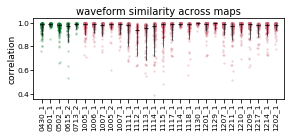

In [17]:
f, ax = plt.subplots(1, 1, figsize=(4.5, 1.5))

PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
POSITIONS = np.arange(N_sessions)
JIT = 0.05

# plot median z-score for each cell
for i, z in enumerate(all_correlations):
    n_cells = z.shape[0]
    jit = np.random.randn(n_cells) * JIT
    ax.scatter(np.full(n_cells, POSITIONS[i])+jit, z, 
                s=PT_SIZE, lw=PT_LW, color=session_colors[i], alpha=0.3, zorder=1)

# mark median and 95th percentiles
ax.plot(POSITIONS, avg_corr, '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=1)
ax.vlines(POSITIONS, pct_5, pct_95, lw=LW_PCT, colors='k', linestyles='solid', zorder=2, alpha=1)

# labels, axes
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_ylabel('correlation', fontsize=9, labelpad=1)
ax.set_xlim(-1, N_sessions)
ax.set_xticks(POSITIONS)
ax.set_xticklabels(session_names, rotation=90)
ax.set_title('waveform similarity across maps', fontsize=10, pad=3)

f.savefig(save_folder + 'waveform_correlations.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
all_correlations_array = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        all_correlations_array = np.append(all_correlations_array, d['correlations'].copy())

print('median correlation across 2-map sessions = {:.4}'.format(np.median(all_correlations_array)))
print('5th percentile correlation across 2-map sessions = {:.4}'.format(np.percentile(all_correlations_array, 5)))

median correlation across 2-map sessions = 0.9859
5th percentile correlation across 2-map sessions = 0.8743


In [23]:
''' plot example rasters and waveforms '''
waveform_colors = np.asarray([[0, 0, 0, 255], [60, 60, 60, 255], [120, 120, 120, 255], # grayscale
                             [153, 119, 0, 255], [221, 170, 51, 255], [238, 204, 102, 255]]) # yellows
waveform_colors = waveform_colors/255
waveform_colors = list(waveform_colors)
for i, c in enumerate(waveform_colors):
    waveform_colors[i] = tuple(c)

In [20]:
def plot_waveforms(d, cell_ID, epoch, ax, wf_color, std_color=None, plot_std=True):
    cell_channels = d['cell_channels']
    waveform_avg = d['waveform_avg'].copy()
    waveform_std = d['waveform_std'].copy()
    cdx = np.where(cells==cell_ID)[0][0]
    if std_color == None:
        std_color = wf_color
    
    # get channel params
    best_channel = cell_channels[cdx]
    window = np.arange(best_channel-6, best_channel+6)
    sp = d['behavior']['sp']
    ycoords = sp['ycoords'][window-3].copy()
    xcoords = sp['xcoords'][window-3].copy()
    ycoords = ycoords/25
    xcoords = xcoords*3
    
    # get waveform params and normalize by epoch 0
    wf_avg = waveform_avg[epoch, cdx, window, :]
    wf_std = waveform_std[epoch, cdx, window, :]
    wf_std = wf_std / np.abs(np.min(waveform_avg[0, cdx, window, :]))
    wf_avg = wf_avg / np.abs(np.min(waveform_avg[0, cdx, window, :]))

    # plot it
    for i, ch in enumerate(window):
        wf_avg[i] = wf_avg[i] - wf_avg[i, 0] # align to channel center
        x = xcoords[i]
        y = ycoords[i]
        x_samples = np.arange(x - n_samples//2, (x + n_samples//2)+1)
        ax.plot(x_samples, wf_avg[i]+y, color=wf_color, lw=0.5, zorder=2)
        if plot_std:
            ax.fill_between(x_samples, (wf_avg[i]+y)-wf_std[i], (wf_avg[i]+y)+wf_std[i], 
                            color=std_color, lw=0.1, alpha=0.2, zorder=1)
    ax.axis('off')

In [21]:
ex_mice = ['Pisa', 'Seattle', 'Toronto', 'Mumbai']
ex_sessions = ['0430_1', '1006_1', '1112_1', '1129_1']
ex_cells = [362, 318, 499, 832]
# Seattle cells to try: 318, 313, 336, 338, 337, 341
# Mumbai cells to try: 832, 472, 477 

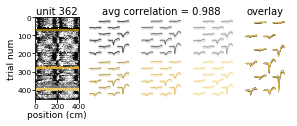

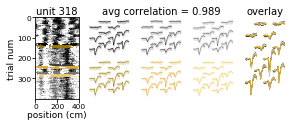

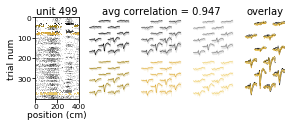

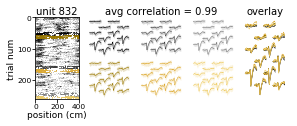

In [24]:
for j, m in enumerate(ex_mice):
    s = ex_sessions[j]
    d = data[m][s]
    A = d['A']
    B = d['B']
    cells = d['cells']
    waveform_avg = d['waveform_avg'].copy()
    waveform_std = d['waveform_std'].copy()
    n_epochs, n_cells, n_channels, n_samples = waveform_avg.shape
    n_pairs = n_epochs//2
    ex_trials = d['epoch_trials']
    assert(n_epochs == ex_trials.shape[0])

    # plotting params
    gs = gridspec.GridSpec(2, n_pairs+2, wspace=0.2, hspace=0)
    f = plt.figure(figsize=((n_pairs)*1.5, 1.5))
    wf_colors = waveform_colors[:n_pairs] + waveform_colors[3:3+n_pairs]
    assert len(wf_colors) == n_epochs
    PT_SIZE = 0.6

    # get cell indices
    cell_ID = ex_cells[j]
    cdx = np.where(cells==cell_ID)[0][0]
    sdx = B[:, cdx].astype(bool)
    
    # compute unfiltered avg correlation
    cell_channels = d['cell_channels'].copy()
    wf_avg = np.zeros((n_epochs, n_cells, 20, n_samples))
    for i, ch in enumerate(cell_channels):
        if ch < 10:
            wf_avg[:, i, :, :] = waveform_avg[:, i, :20, :]
        elif ch > 375:
            wf_avg[:, i, :, :] = waveform_avg[:, i, 365:, :]
        else:
            wf_avg[:, i, :, :] = waveform_avg[:, i, ch-10:ch+10, :]
    avg_corr = np.zeros(n_cells)
    for p in range(n_pairs):
        i = 2*p
        flat_wf_avg_pre = np.reshape(wf_avg[i, :, :, :], (n_cells, -1))
        flat_wf_avg_post = np.reshape(wf_avg[i+1, :, :, :], (n_cells, -1))
        flat_wf_avg = np.row_stack((flat_wf_avg_pre, flat_wf_avg_post))
        corr_vec = np.abs(pdist(flat_wf_avg, 'correlation')-1)
        correlations = np.diagonal(squareform(corr_vec), offset=n_cells)
        avg_corr += correlations
    avg_corr = avg_corr/n_pairs

    # plot raster, color points for example waveforms
    ax0 = plt.subplot(gs[:, 0])
    trials = A[:, 2]
    max_trial = np.max(A[:, 2]) + 1
    ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=PT_SIZE, alpha=.1)
    for i in range(n_epochs):
        trial_idx = (trials[sdx] >= ex_trials[i, 0]) & (trials[sdx] <= ex_trials[i, 1])
        ax0.scatter(A[:, 0][sdx][trial_idx], A[:, 2][sdx][trial_idx], 
                   color=wf_colors[i], lw=0, s=PT_SIZE, alpha=0.8)
    ax0.set_xlim([0, 400])
    ylim_ax = [0, max_trial]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_yticks(np.arange(0, max_trial, 100))
    ax0.set_xticks([0, 200, 400])
    ax0.set_title('unit {}'.format(cell_ID), fontsize=10, pad=3)
    ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1)
    ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
    
    # plot example waveforms
    ax2 = plt.subplot(gs[:, n_pairs+1])
    for i in range(n_epochs):
        if i < n_pairs:
            ax1 = plt.subplot(gs[0, i+1])
        else:
            ax1 = plt.subplot(gs[1, i-n_pairs+1])
        plot_waveforms(d, cell_ID, i, ax1, wf_colors[i])
        plot_waveforms(d, cell_ID, i, ax2, wf_colors[i], plot_std=False)
        if i == n_pairs//2:
            ax1.set_title('avg correlation = {}'.format(np.round(avg_corr[cdx], 3)), fontsize=10, pad=3)
    ax2.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax2.set_title('overlay', fontsize=10, pad=3)
    
    f.savefig(save_folder + '{}_{}_example_cell_{}.png'.format(m, s, cell_ID), dpi=400, bbox_inches='tight')
    plt.show()